# Investigating Transfer Learning from German to U.S. Traffic Signs

This notebook demonstrates how to load an ImageNet-pretrained ResNet50 model and investigate transfer learning by pretraining the model on a traffic-sign dataset from one country and fine-tuning it to predict traffic signs from another country, using the German-to-U.S. scenario as a case study.

## Datasets
German Traffic Signs (German Traffic Sign Recognition Benchmark GTSRB):
J. Stallkamp, M. Schlipsing, J. Salmen, and C. Igel. The German Traffic Sign Recognition Benchmark: A multi-class classification competition. In Proceedings of the IEEE International Joint Conference on Neural Networks, pages 1453–1460. 2011.

U.S. Traffic Signs (LISA Traffic Sign Dataset):
Andreas Møgelmose, Mohan M. Trivedi, and Thomas B. Moeslund, “Vision based Traffic Sign Detection and Analysis for Intelligent Driver Assistance Systems: Perspectives and Survey,” IEEE Transactions on Intelligent Transportation Systems, 2012.

In [1]:
!pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [23]:
import os
import requests
import zipfile
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet50_Weights, resnet50
from torchvision.datasets import GTSRB
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [3]:
# For reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [25]:
base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
base_model.eval()

# Save the model weights
torch.save(base_model.state_dict(), "model/resnet50_imagenet_weights.pth")
print(base_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
# 43 GTSRB class labels
class_names = [
    "speed limit (20km/h)", "speed limit (30km/h)", "speed limit (50km/h)", "speed limit (60km/h)",
    "speed limit (70km/h)", "speed limit (80km/h)", "end of speed limit (80km/h)", "speed limit (100km/h)",
    "speed limit (120km/h)", "no passing", "no passing for vehicles over 3.5 metric tons",
    "right-of-way at the next intersection", "priority road", "yield", "stop", "no vehicles",
    "vehicles over 3.5 metric tons prohibited", "no entry", "general caution", "dangerous curve to the left",
    "dangerous curve to the right", "double curve", "bumpy road", "slippery road", "road narrows on the right",
    "road work", "traffic signals", "pedestrians", "children crossing", "bicycles crossing",
    "beware of ice/snow", "wild animals crossing", "end of all speed and passing limits",
    "turn right ahead", "turn left ahead", "ahead only", "go straight or right", "go straight or left",
    "keep right", "keep left", "roundabout mandatory", "end of no passing",
    "end of no passing by vehicles over 3.5 metric tons"
]

data_dir = "./data/GTSRB"
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # match ResNet input size
    transforms.ToTensor(),
])

# download/train split
train_ds_GTSRB = GTSRB(root=data_dir, split="train",
                 transform=transform, download=False)
test_ds_GTSRB  = GTSRB(root=data_dir, split="test",
                 transform=transform, download=False)

# wrap in DataLoader
train_loader_GTSRB = DataLoader(train_ds_GTSRB, batch_size=64, shuffle=True, num_workers=4)
test_loader_GTSRB  = DataLoader(test_ds_GTSRB, batch_size=64, shuffle=False, num_workers=4)

print(f"Found {len(train_ds_GTSRB)} training and {len(test_ds_GTSRB)} test samples.")

Found 26640 training and 12630 test samples.


In [18]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from lisa import LISA # local file

# mean/std the authors report (https://github.com/AminJun/lisa?tab=readme-ov-file)
mean = [0.4563, 0.4076, 0.3895]
std  = [0.2298, 0.2144, 0.2259]

# specify transforms
transform = transforms.Compose([
  transforms.Resize((224, 224)), # match ResNet50 input
  transforms.ToTensor(),
  transforms.Normalize(mean, std),
])

# download/train split
train_ds_LISA = LISA(root="data/LISA",
                download=False,
                train=True,
                transform=transform)
val_ds_LISA   = LISA(root="data/LISA",
                download=False,
                train=False,
                transform=transform)

print(f"Train: {len(train_ds_LISA)} images  –  Val: {len(val_ds_LISA)} images")

# wrap in dataloader
train_loader_LISA = DataLoader(train_ds_LISA, batch_size=64, shuffle=True,  num_workers=4)
val_loader_LISA   = DataLoader(val_ds_LISA,   batch_size=64, shuffle=False, num_workers=4)

Train: 6621 images  –  Val: 1234 images


In [27]:
num_classes = 43  # gtsrb has 43 known classes

# adapt the head of the pretrained resnet
finetuned_model.fc = nn.Linear(finetuned_model.fc.in_features, num_classes)
finetuned_model = finetuned_model.to(device)

# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(finetuned_model.parameters(), lr=1e-4)

# initialize best model tracking
best_acc = 0.0
best_epoch = 0
best_model_wts = copy.deepcopy(finetuned_model.state_dict())

# training loop
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    finetuned_model.train()
    running_loss = 0.0

    # training step
    for imgs, labels in train_loader_GTSRB:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = finetuned_model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_loader_GTSRB.dataset)

    # validation step
    finetuned_model.eval()
    correct = 0
    with torch.no_grad():
        for imgs, labels in test_loader_GTSRB:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = finetuned_model(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()

    val_acc = correct / len(test_loader_GTSRB.dataset)

    # update best model if improved
    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch
        best_model_wts = copy.deepcopy(finetuned_model.state_dict())

    print(f"epoch {epoch:2d}/{num_epochs} — "
          f"train loss: {epoch_loss:.4f} — val acc: {val_acc:.4f}")

# load and save best model
finetuned_model.load_state_dict(best_model_wts)
torch.save(finetuned_model.state_dict(), "./model/resnet50_gtsrb_best.pth")
print(f"Best model saved from epoch {best_epoch} with val acc: {best_acc:.4f}")

NameError: name 'finetuned_model' is not defined

In [21]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define number of gtsrb classes
num_classes = 43

# -------------------------------
# base model (imagenet pretrained, random fc layer)
# -------------------------------
base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)  # random init
base_model = base_model.to(device)
base_model.eval()

# evaluate base model
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader_GTSRB:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = base_model(imgs)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
base_acc = correct / total
print(f"base model (imagenet, random fc) accuracy on gtsrb: {base_acc:.4f}")

# -------------------------------
# pretrained + fine-tuned model
# -------------------------------
pretrained_model = resnet50(weights=None)
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)
pretrained_model.load_state_dict(torch.load("./model/resnet50_gtsrb_best.pth"))
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()

# evaluate fine-tuned model
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader_GTSRB:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = pretrained_model(imgs)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
finetuned_acc = correct / total
print(f"fine-tuned model accuracy on gtsrb: {finetuned_acc:.4f}")

epoch  1/10 — train loss: 0.1269 — val acc: 0.9873
epoch  2/10 — train loss: 0.0112 — val acc: 0.9812
epoch  3/10 — train loss: 0.0037 — val acc: 0.9765
epoch  4/10 — train loss: 0.0140 — val acc: 0.9876
epoch  5/10 — train loss: 0.0061 — val acc: 0.9873
epoch  6/10 — train loss: 0.0008 — val acc: 0.9890
epoch  7/10 — train loss: 0.0001 — val acc: 0.9897
epoch  8/10 — train loss: 0.0001 — val acc: 0.9894
epoch  9/10 — train loss: 0.0001 — val acc: 0.9907
epoch 10/10 — train loss: 0.0001 — val acc: 0.9893
Best model saved from epoch 9 with val acc: 0.9907


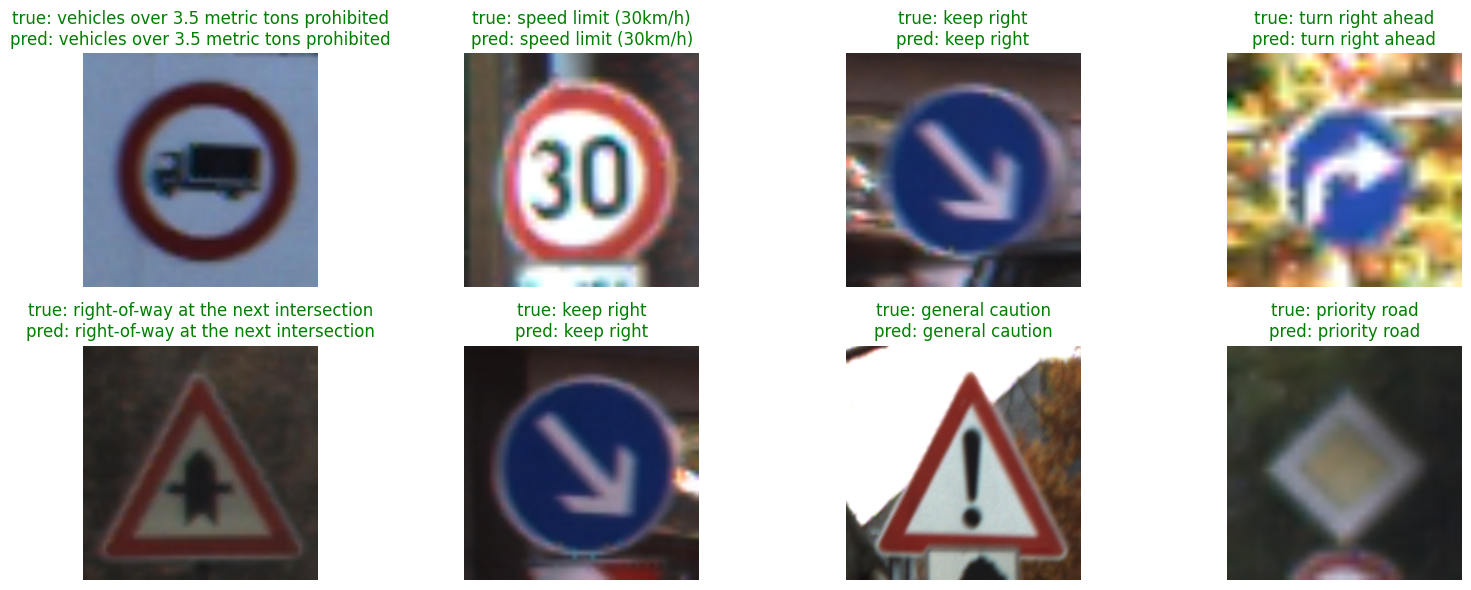

In [26]:
# put model in evaluation mode
model.eval()

# get a batch of test data
images, labels = next(iter(test_loader_GTSRB))
images, labels = images.to(device), labels.to(device)

# get predictions
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# number of examples to show
num_show = 8
plt.figure(figsize=(16, 6))
for idx in range(num_show):
    img = images[idx].cpu().permute(1, 2, 0).numpy()
    label = labels[idx].item()
    pred = preds[idx].item()
    correct = (label == pred)
    
    plt.subplot(2, 4, idx + 1)
    plt.imshow(img)
    plt.title(f"true: {class_names[label]}\n"
              f"pred: {class_names[pred]}", 
              color="green" if correct else "red")
    plt.axis("off")

plt.tight_layout()
plt.show()